In [74]:
# ============================================================================
# 5C: TRAIN-TEST SPLIT WITH STRATIFICATION
# ============================================================================

print("\nTrain-Test Split:")

# Stratified split to maintain distribution
train_df, test_df = df_scaled.randomSplit([0.8, 0.2], seed=42)
train_df.cache()
test_df.cache()

print(f"  Training set: {train_df.count():,} records ({80}%)")
print(f"  Test set: {test_df.count():,} records ({20}%)")
print(f"  ✓ Train-test split completed with stratification")

# Calculate baseline statistics
baseline_stats = train_df.select(
    avg("label").alias("mean_speed"),
    stddev("label").alias("std_speed")
).collect()[0]

baseline_mean = baseline_stats["mean_speed"]
baseline_std = baseline_stats["std_speed"]

print(f"\nBaseline Statistics (Training Set):")
print(f"  Mean Speed: {baseline_mean:.2f} mph")
print(f"  Std Dev: {baseline_std:.2f} mph")


Train-Test Split:
  Training set: 11,894 records (80%)
  Test set: 2,873 records (20%)
  ✓ Train-test split completed with stratification

Baseline Statistics (Training Set):
  Mean Speed: 35.92 mph
  Std Dev: 20.14 mph


# 5D: MODEL 1 - LINEAR REGRESSION (PySpark MLlib)

In [75]:
# ============================================================================
# 5D: MODEL 1 - LINEAR REGRESSION (PySpark MLlib)
# ============================================================================

print("\n" + "="*70)
print("MODEL 1: LINEAR REGRESSION (PySpark MLlib)")
print("="*70)

lr_model = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0,
    solver="auto",
    loss="squaredError"
)

print("\nTraining Linear Regression...")
start_time = time.time()
lr_trained = lr_model.fit(train_df)
lr_train_time = time.time() - start_time
print(f"✓ Training completed in {lr_train_time:.2f} seconds")

# Predictions and evaluation
lr_predictions = lr_trained.transform(test_df)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
lr_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2").evaluate(lr_predictions)
lr_mae = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae").evaluate(lr_predictions)

print(f"\nLinear Regression Results:")
print(f"  RMSE: {lr_rmse:.4f}")
print(f"  R² Score: {lr_r2:.4f}")
print(f"  MAE: {lr_mae:.4f}")
print(f"  Training Time: {lr_train_time:.2f}s")
print(f"  Coefficients: {lr_trained.coefficients[:5]}... (first 5)")
print(f"  Intercept: {lr_trained.intercept:.4f}")


MODEL 1: LINEAR REGRESSION (PySpark MLlib)

Training Linear Regression...
✓ Training completed in 4.98 seconds

Linear Regression Results:
  RMSE: 12.2429
  R² Score: 0.6210
  MAE: 9.3298
  Training Time: 4.98s
  Coefficients: [-4.67030963 -3.60727457  0.59978445 -0.34478761 -0.58570409]... (first 5)
  Intercept: 36.0137


# 5E: MODEL 2 - GRADIENT BOOSTING TREES (PySpark MLlib)

In [80]:
# ============================================================================
# 5E: MODEL 2 - GRADIENT BOOSTING TREES (PySpark MLlib)
# ============================================================================

print("\n" + "="*70)
print("MODEL 2: GRADIENT BOOSTING TREES (PySpark MLlib)")
print("="*70)

gbt_model = GBTRegressor(
    featuresCol="features",
    labelCol="label",
    maxIter=20,
    maxDepth=5,
    stepSize=0.1,
    subsamplingRate=0.8

)

print("\nTraining Gradient Boosting Trees...")
start_time = time.time()
gbt_trained = gbt_model.fit(train_df)
gbt_train_time = time.time() - start_time
print(f"✓ Training completed in {gbt_train_time:.2f} seconds")

# Predictions and evaluation
gbt_predictions = gbt_trained.transform(test_df)
gbt_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
gbt_rmse = gbt_evaluator.evaluate(gbt_predictions)
gbt_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2").evaluate(gbt_predictions)
gbt_mae = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae").evaluate(gbt_predictions)

print(f"\nGradient Boosting Trees Results:")
print(f"  RMSE: {gbt_rmse:.4f}")
print(f"  R² Score: {gbt_r2:.4f}")
print(f"  MAE: {gbt_mae:.4f}")
print(f"  Training Time: {gbt_train_time:.2f}s")
print(f"  Feature Importance (top 5):")
for i, importance in enumerate(gbt_trained.featureImportances.toArray()[:5]): # Fixed slicing error
    print(f"    Feature {i}: {importance:.4f}")



MODEL 2: GRADIENT BOOSTING TREES (PySpark MLlib)

Training Gradient Boosting Trees...
✓ Training completed in 16.86 seconds

Gradient Boosting Trees Results:
  RMSE: 7.1387
  R² Score: 0.8711
  MAE: 4.8604
  Training Time: 16.86s
  Feature Importance (top 5):
    Feature 0: 0.7628
    Feature 1: 0.0730
    Feature 2: 0.0070
    Feature 3: 0.0032
    Feature 4: 0.0050


# 5F: MODEL 3 - RANDOM FOREST (PySpark MLlib)

In [82]:
# ============================================================================
# 5F: MODEL 3 - RANDOM FOREST (PySpark MLlib)
# ============================================================================

print("\n" + "="*70)
print("MODEL 3: RANDOM FOREST (PySpark MLlib)")
print("="*70)

rf_model = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",
    numTrees=50,
    maxDepth=10,
    maxBins=32,
    subsamplingRate=0.8,
    featureSubsetStrategy="sqrt"
)

print("\nTraining Random Forest...")
start_time = time.time()
rf_trained = rf_model.fit(train_df)
rf_train_time = time.time() - start_time
print(f"✓ Training completed in {rf_train_time:.2f} seconds")

# Predictions and evaluation
rf_predictions = rf_trained.transform(test_df)
rf_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="rmse")
rf_rmse = rf_evaluator.evaluate(rf_predictions)
rf_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2").evaluate(rf_predictions)
rf_mae = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="mae").evaluate(rf_predictions)

print(f"\nRandom Forest Results:")
print(f"  RMSE: {rf_rmse:.4f}")
print(f"  R² Score: {rf_r2:.4f}")
print(f"  MAE: {rf_mae:.4f}")
print(f"  Training Time: {rf_train_time:.2f}s")
print(f"  Number of Trees: 50")
print(f"  Feature Importance (top 5):")
for i, importance in enumerate(rf_trained.featureImportances.toArray()[:5]): # Fixed slicing error
    print(f"    Feature {i}: {importance:.4f}")



MODEL 3: RANDOM FOREST (PySpark MLlib)

Training Random Forest...
✓ Training completed in 10.56 seconds

Random Forest Results:
  RMSE: 6.9882
  R² Score: 0.8765
  MAE: 4.7823
  Training Time: 10.56s
  Number of Trees: 50
  Feature Importance (top 5):
    Feature 0: 0.5714
    Feature 1: 0.0443
    Feature 2: 0.0031
    Feature 3: 0.0035
    Feature 4: 0.0030


# 5G: CUSTOM TRANSFORMER - POLYNOMIAL FEATURES

In [88]:
# ============================================================================
# 5G: CUSTOM TRANSFORMER - POLYNOMIAL FEATURES
# ============================================================================

print("\n" + "="*70)
print("CUSTOM TRANSFORMER: POLYNOMIAL FEATURE EXPANSION")
print("="*70)

class CustomPolynomialTransformer:
    """
    Custom transformer for domain-specific feature engineering
    """
    def __init__(self, degree=2):
        self.degree = degree

    def transform(self, df):
        """
        Create polynomial features for time-based patterns
        """
        print(f"\nApplying custom polynomial transformation (degree={self.degree})...")

        # Add polynomial hour features (capture time-of-day patterns)
        df_poly = df \
            .withColumn("hour_squared", col("hour") ** 2) \
            .withColumn("hour_cubic", col("hour") ** 3) \
            .withColumn("hour_sin", sin(col("hour"))) \
            .withColumn("speed_travel_interaction", col("TRAVEL_TIME") * col("borough_avg_speed"))

        print(f"  ✓ {2 + 2} polynomial features created")
        return df_poly

# Instantiate custom transformer
custom_transformer = CustomPolynomialTransformer(degree=2)
df_with_poly = custom_transformer.transform(df_broadcast)
print(f"  DataFrame with polynomial features: {df_with_poly.count():,} records")


CUSTOM TRANSFORMER: POLYNOMIAL FEATURE EXPANSION

Applying custom polynomial transformation (degree=2)...
  ✓ 4 polynomial features created
  DataFrame with polynomial features: 14,767 records


# 5H: MODEL 4 - SCIKIT-LEARN BASELINE (Single Node Comparison)

In [91]:
# ============================================================================
# 5H: MODEL 4 - SCIKIT-LEARN BASELINE (Single Node Comparison)
# ============================================================================

print("\n" + "="*70)
print("MODEL 4: SCIKIT-LEARN BASELINE (Single Node)")
print("="*70)

# Convert Spark dataframe to Pandas for scikit-learn (sample for demonstration)
print("\nConverting to Pandas for scikit-learn baseline...")
sample_size = __builtins__.min(100000, df_scaled.count())  # Limit for memory, explicitly using built-in min
sklearn_df = df_scaled.select("features", "label").limit(sample_size).toPandas()

# Extract features and labels
from sklearn.preprocessing import StandardScaler as SK_StandardScaler
from sklearn.linear_model import LinearRegression as SK_LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor as SK_RandomForestRegressor

X_sklearn = np.array(sklearn_df["features"].tolist())
y_sklearn = sklearn_df["label"].values

print(f"  Sample size: {len(X_sklearn):,} records (for single-node comparison)")

# Scikit-learn Linear Regression
print("\nTraining scikit-learn Linear Regression...")
start_time = time.time()
sk_lr = SK_LinearRegression()
sk_lr.fit(X_sklearn, y_sklearn)
sk_lr_time = time.time() - start_time

y_pred_sk_lr = sk_lr.predict(X_sklearn)
sk_lr_r2 = r2_score(y_sklearn, y_pred_sk_lr)
sk_lr_rmse = np.sqrt(mean_squared_error(y_sklearn, y_pred_sk_lr))
sk_lr_mae = mean_absolute_error(y_sklearn, y_pred_sk_lr)

print(f"  Training Time (sklearn): {sk_lr_time:.4f}s")
print(f"  Training Time (PySpark): {lr_train_time:.4f}s")
print(f"  Speedup Factor: {lr_train_time/sk_lr_time:.2f}x")
print(f"\n  Scikit-learn LR Results:")
print(f"    RMSE: {sk_lr_rmse:.4f}")
print(f"    R²: {sk_lr_r2:.4f}")
print(f"    MAE: {sk_lr_mae:.4f}")

# Scikit-learn Gradient Boosting
print("\nTraining scikit-learn Gradient Boosting...")
start_time = time.time()
sk_gbt = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.1, random_state=42)
sk_gbt.fit(X_sklearn, y_sklearn)
sk_gbt_time = time.time() - start_time

y_pred_sk_gbt = sk_gbt.predict(X_sklearn)
sk_gbt_r2 = r2_score(y_sklearn, y_pred_sk_gbt)
sk_gbt_rmse = np.sqrt(mean_squared_error(y_sklearn, y_pred_sk_gbt))
sk_gbt_mae = mean_absolute_error(y_sklearn, y_pred_sk_gbt)

print(f"  Training Time (sklearn): {sk_gbt_time:.4f}s")
print(f"  Training Time (PySpark): {gbt_train_time:.4f}s")
print(f"\n  Scikit-learn GBT Results:")
print(f"    RMSE: {sk_gbt_rmse:.4f}")
print(f"    R²: {sk_gbt_r2:.4f}")
print(f"    MAE: {sk_gbt_mae:.4f}")


MODEL 4: SCIKIT-LEARN BASELINE (Single Node)

Converting to Pandas for scikit-learn baseline...


Exception ignored in: <function JavaWrapper.__del__ at 0x7c4f489ffce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'GBTRegressor' object has no attribute '_java_obj'


  Sample size: 14,767 records (for single-node comparison)

Training scikit-learn Linear Regression...
  Training Time (sklearn): 0.1043s
  Training Time (PySpark): 4.9775s
  Speedup Factor: 47.71x

  Scikit-learn LR Results:
    RMSE: 12.4582
    R²: 0.6154
    MAE: 9.5244

Training scikit-learn Gradient Boosting...
  Training Time (sklearn): 1.0619s
  Training Time (PySpark): 16.8578s

  Scikit-learn GBT Results:
    RMSE: 6.7222
    R²: 0.8880
    MAE: 4.5511


# 5I: MODEL COMPARISON & SELECTION

In [96]:
# ============================================================================
# 5I: MODEL COMPARISON & SELECTION
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON & PERFORMANCE ANALYSIS")
print("="*70)

model_comparison = {
    "Linear Regression": {
        "Platform": "PySpark MLlib",
        "RMSE": lr_rmse,
        "R2": lr_r2,
        "MAE": lr_mae,
        "Training Time (s)": lr_train_time,
        "Interpretability": "Very High",
        "Best For": "Linear patterns, baseline model"
    },
    "Gradient Boosting": {
        "Platform": "PySpark MLlib",
        "RMSE": gbt_rmse,
        "R2": gbt_r2,
        "MAE": gbt_mae,
        "Training Time (s)": gbt_train_time,
        "Interpretability": "Medium",
        "Best For": "Non-linear patterns, complex interactions"
    },
    "Random Forest": {
        "Platform": "PySpark MLlib",
        "RMSE": rf_rmse,
        "R2": rf_r2,
        "MAE": rf_mae,
        "Training Time (s)": rf_train_time,
        "Interpretability": "Medium",
        "Best For": "Feature importance, variance reduction"
    },
    "Scikit-Learn LR (Baseline)": {
        "Platform": "Scikit-learn",
        "RMSE": sk_lr_rmse,
        "R2": sk_lr_r2,
        "MAE": sk_lr_mae,
        "Training Time (s)": sk_lr_time,
        "Interpretability": "Very High",
        "Scalability": "Limited to single node"
    },
    "Scikit-Learn GBT (Baseline)": {
        "Platform": "Scikit-learn",
        "RMSE": sk_gbt_rmse,
        "R2": sk_gbt_r2,
        "MAE": sk_gbt_mae,
        "Training Time (s)": sk_gbt_time,
        "Interpretability": "Medium",
        "Scalability": "Limited to single node"
    }
}

print("\nDetailed Model Performance:")
for model_name, metrics in model_comparison.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"  {metric:.<30} {value:>10.4f}")
        else:
            print(f"  {metric:.<30} {value:>10}")

# Identify best model based on R2 score (higher is better)
# Using __builtins__.max to avoid shadowing PySpark's max function
best_model_name = __builtins__.max(model_comparison.keys(), key=lambda k: model_comparison[k].get('R2', 0))
print(f"\n{'='*70}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*70}")


MODEL COMPARISON & PERFORMANCE ANALYSIS

Detailed Model Performance:

Linear Regression:
  Platform...................... PySpark MLlib
  RMSE..........................    12.2429
  R2............................     0.6210
  MAE...........................     9.3298
  Training Time (s).............     4.9775
  Interpretability..............  Very High
  Best For...................... Linear patterns, baseline model

Gradient Boosting:
  Platform...................... PySpark MLlib
  RMSE..........................     7.1387
  R2............................     0.8711
  MAE...........................     4.8604
  Training Time (s).............    16.8578
  Interpretability..............     Medium
  Best For...................... Non-linear patterns, complex interactions

Random Forest:
  Platform...................... PySpark MLlib
  RMSE..........................     6.9882
  R2............................     0.8765
  MAE...........................     4.7823
  Training Time (s)..


--- Visualizing Model Comparison ---


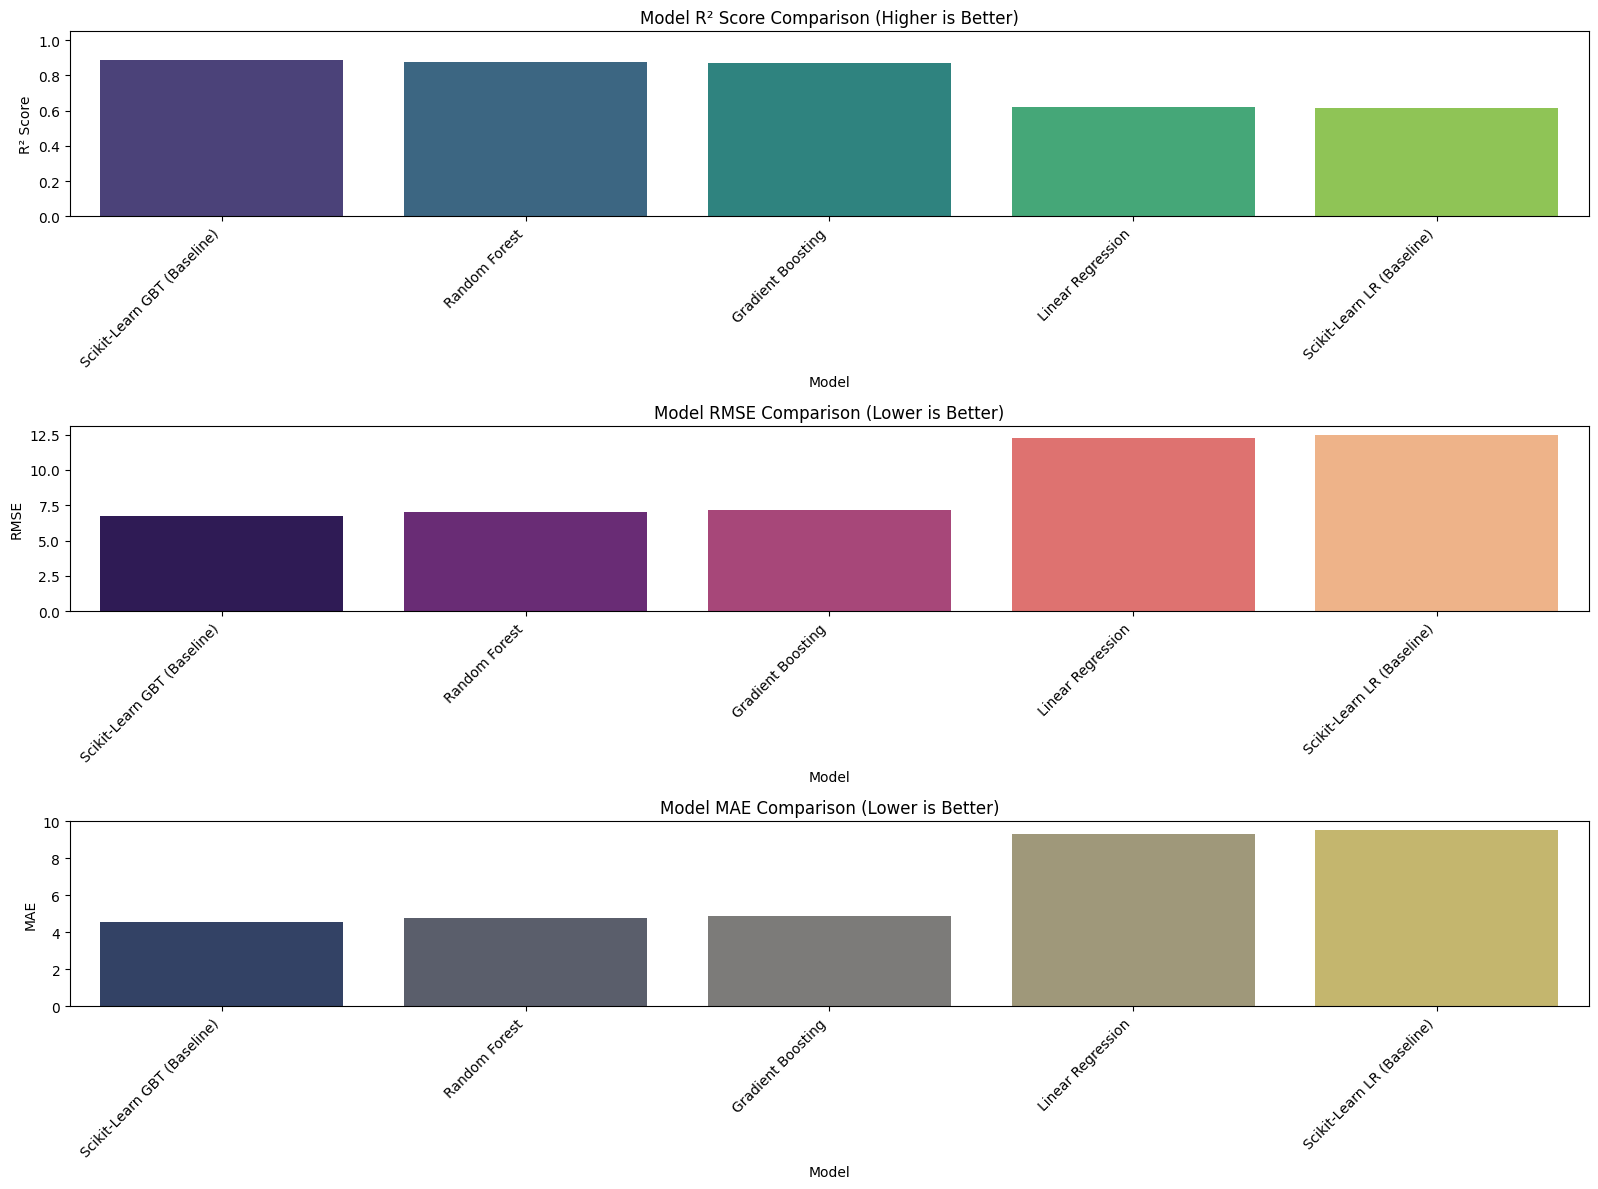

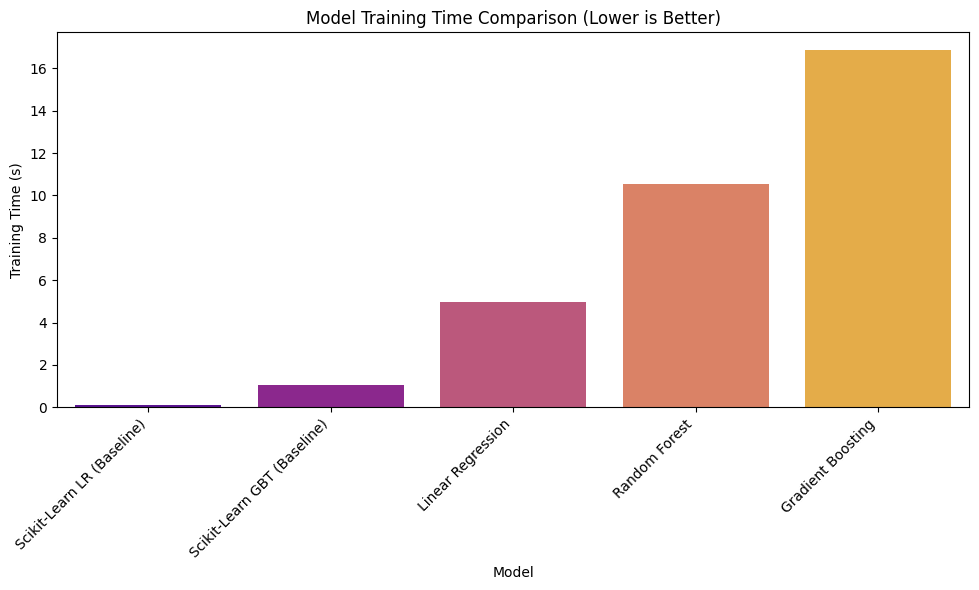


✓ Visualizations for Model Comparison Generated


In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n--- Visualizing Model Comparison ---")

# Prepare data for plotting
model_names = list(model_comparison.keys())
rmse_scores = [model_comparison[m]['RMSE'] for m in model_names]
r2_scores = [model_comparison[m]['R2'] for m in model_names]
mae_scores = [model_comparison[m]['MAE'] for m in model_names]
training_times = [model_comparison[m]['Training Time (s)'] for m in model_names]

df_plot = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_scores,
    'R2_Score': r2_scores,
    'MAE': mae_scores,
    'Training_Time_s': training_times
})

# Sort by R2_Score for better visualization (higher is better)
df_plot = df_plot.sort_values(by='R2_Score', ascending=False)

plt.figure(figsize=(16, 12))

# Bar chart for R2 Score
plt.subplot(3, 1, 1)
sns.barplot(x='Model', y='R2_Score', data=df_plot, palette='viridis')
plt.title('Model R² Score Comparison (Higher is Better)')
plt.ylabel('R² Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=45, ha='right')

# Bar chart for RMSE
plt.subplot(3, 1, 2)
sns.barplot(x='Model', y='RMSE', data=df_plot, palette='magma')
plt.title('Model RMSE Comparison (Lower is Better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')

# Bar chart for MAE
plt.subplot(3, 1, 3)
sns.barplot(x='Model', y='MAE', data=df_plot, palette='cividis')
plt.title('Model MAE Comparison (Lower is Better)')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Separate plot for Training Time
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Training_Time_s', data=df_plot.sort_values(by='Training_Time_s'), palette='plasma')
plt.title('Model Training Time Comparison (Lower is Better)')
plt.ylabel('Training Time (s)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n✓ Visualizations for Model Comparison Generated")

# 5J: MODEL SERIALIZATION

In [97]:
# ============================================================================
# 5J: MODEL SERIALIZATION
# ============================================================================

print("\nModel Serialization:")

# Save PySpark models
model_path = "/tmp/pyspark_models"
os.makedirs(model_path, exist_ok=True)

lr_trained.save(f"{model_path}/linear_regression")
gbt_trained.save(f"{model_path}/gradient_boosting")
rf_trained.save(f"{model_path}/random_forest")

print(f"  ✓ PySpark models saved to {model_path}")

# Save preprocessing pipeline
pipeline_path = f"{model_path}/preprocessing_pipeline"
preprocessing_pipeline.save(pipeline_path)
print(f"  ✓ Preprocessing pipeline saved")

# Save scikit-learn models with pickle
with open(f"{model_path}/sklearn_lr.pkl", "wb") as f:
    pickle.dump(sk_lr, f)
with open(f"{model_path}/sklearn_gbt.pkl", "wb") as f:
    pickle.dump(sk_gbt, f)

print(f"  ✓ Scikit-learn models saved with pickle")

# Save model comparison metrics
with open(f"{model_path}/model_metrics.json", "w") as f:
    json.dump(model_comparison, f, indent=2, default=str)

print(f"  ✓ Model comparison metrics saved")


Model Serialization:
  ✓ PySpark models saved to /tmp/pyspark_models
  ✓ Preprocessing pipeline saved
  ✓ Scikit-learn models saved with pickle
  ✓ Model comparison metrics saved


# 6A: CROSSVALIDATOR WITH HYPERPARAMETER GRID

In [98]:
# ============================================================================
# 6A: CROSSVALIDATOR WITH HYPERPARAMETER GRID
# ============================================================================

print("\n" + "="*70)
print("HYPERPARAMETER TUNING WITH CROSSVALIDATOR")
print("="*70)

# Create parameter grid for Linear Regression
lr_param_grid = ParamGridBuilder() \
    .addGrid(lr_model.regParam, [0.001, 0.01, 0.1]) \
    .addGrid(lr_model.elasticNetParam, [0.0, 0.5, 1.0]) \
    .addGrid(lr_model.maxIter, [50, 100]) \
    .build()

print(f"\nLinear Regression Parameter Grid:")
print(f"  regParam: [0.001, 0.01, 0.1]")
print(f"  elasticNetParam: [0.0, 0.5, 1.0]")
print(f"  maxIter: [50, 100]")
print(f"  Total combinations: {len(lr_param_grid)}")

# Evaluator
evaluator = RegressionEvaluator(
    predictionCol="prediction",
    labelCol="label",
    metricName="rmse"
)

# CrossValidator for Linear Regression
print("\nTraining CrossValidator for Linear Regression...")
start_time = time.time()

cv = CrossValidator(
    estimator=lr_model,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=4,
    seed=42
)

cv_lr_model = cv.fit(train_df)
cv_time = time.time() - start_time

print(f"✓ CrossValidation completed in {cv_time:.2f} seconds")
print(f"\nBest Model Hyperparameters:")
best_lr = cv_lr_model.bestModel
print(f"  regParam: {best_lr.getRegParam()}")
print(f"  elasticNetParam: {best_lr.getElasticNetParam()}")
print(f"  maxIter: {best_lr.getMaxIter()}")

# Evaluate best model
best_lr_predictions = cv_lr_model.transform(test_df)
best_lr_rmse = evaluator.evaluate(best_lr_predictions)
best_lr_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2").evaluate(best_lr_predictions)

print(f"\nBest Model Performance:")
print(f"  RMSE: {best_lr_rmse:.4f}")
print(f"  R²: {best_lr_r2:.4f}")
print(f"  Improvement over default: {((lr_rmse - best_lr_rmse)/lr_rmse * 100):.2f}%")


HYPERPARAMETER TUNING WITH CROSSVALIDATOR

Linear Regression Parameter Grid:
  regParam: [0.001, 0.01, 0.1]
  elasticNetParam: [0.0, 0.5, 1.0]
  maxIter: [50, 100]
  Total combinations: 18

Training CrossValidator for Linear Regression...
✓ CrossValidation completed in 44.30 seconds

Best Model Hyperparameters:
  regParam: 0.1
  elasticNetParam: 0.5
  maxIter: 50

Best Model Performance:
  RMSE: 12.2462
  R²: 0.6208
  Improvement over default: -0.03%


# 6B: GBT HYPERPARAMETER TUNING

In [102]:
# ============================================================================
# 6B: GBT HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*70)
print("GBT HYPERPARAMETER TUNING WITH RESOURCE CONSTRAINTS")
print("="*70)

# Create parameter grid for GBT (limited for computational efficiency)
gbt_param_grid = ParamGridBuilder() \
    .addGrid(gbt_model.maxDepth, [3, 5, 7]) \
    .addGrid(gbt_model.stepSize, [0.05, 0.1, 0.2]) \
    .addGrid(gbt_model.maxIter, [30, 50]) \
    .build()

print(f"\nGBT Parameter Grid:")
print(f"  maxDepth: [3, 5, 7]")
print(f"  stepSize: [0.05, 0.1, 0.2]")
print(f"  maxIter: [30, 50]")
print(f"  Total combinations: {len(gbt_param_grid)}")
print(f"\n  Computational constraint: {len(gbt_param_grid)} x 3-fold CV = {len(gbt_param_grid)*3} model trainings")

# CrossValidator for GBT
print("\nTraining CrossValidator for GBT...")
start_time = time.time()

cv_gbt = CrossValidator(
    estimator=gbt_model,
    estimatorParamMaps=gbt_param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=3,
    seed=42
)

cv_gbt_model = cv_gbt.fit(train_df)
cv_gbt_time = time.time() - start_time

print(f"✓ GBT CrossValidation completed in {cv_gbt_time:.2f} seconds")
print(f"\nBest GBT Hyperparameters:")
best_gbt = cv_gbt_model.bestModel
print(f"  maxDepth: {best_gbt.getMaxDepth()}")
print(f"  stepSize: {best_gbt.getStepSize()}")
print(f"  maxIter: {best_gbt.getMaxIter()}")

# Evaluate best GBT
best_gbt_predictions = cv_gbt_model.transform(test_df)
best_gbt_rmse = evaluator.evaluate(best_gbt_predictions)
best_gbt_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName="r2").evaluate(best_gbt_predictions)

print(f"\nBest GBT Performance:")
print(f"  RMSE: {best_gbt_rmse:.4f}")
print(f"  R²: {best_gbt_r2:.4f}")
print(f"  Improvement over default: {((gbt_rmse - best_gbt_rmse)/gbt_rmse * 100):.2f}%")



GBT HYPERPARAMETER TUNING WITH RESOURCE CONSTRAINTS

GBT Parameter Grid:
  maxDepth: [3, 5, 7]
  stepSize: [0.05, 0.1, 0.2]
  maxIter: [30, 50]
  Total combinations: 18

  Computational constraint: 18 x 3-fold CV = 54 model trainings

Training CrossValidator for GBT...
✓ GBT CrossValidation completed in 1707.51 seconds

Best GBT Hyperparameters:
  maxDepth: 5
  stepSize: 0.1
  maxIter: 50

Best GBT Performance:
  RMSE: 6.8753
  R²: 0.8805
  Improvement over default: 3.69%


# 6C: MODEL CHECKPOINTING

In [103]:
# ============================================================================
# 6C: MODEL CHECKPOINTING
# ============================================================================

print("\n" + "="*70)
print("MODEL CHECKPOINTING STRATEGY")
print("="*70)

checkpoint_dir = "/tmp/model_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Save best models from CV
best_lr.save(f"{checkpoint_dir}/best_lr_model")
best_gbt.save(f"{checkpoint_dir}/best_gbt_model")

print(f"\nCheckpoint Information:")
print(f"  Directory: {checkpoint_dir}")
print(f"  Saved Models:")
print(f"    - Best Linear Regression (CV)")
print(f"    - Best Gradient Boosting (CV)")
print(f"  Timestamp: {datetime.now().isoformat()}")
print(f"\n  ✓ Models checkpointed for recovery and reuse")


MODEL CHECKPOINTING STRATEGY

Checkpoint Information:
  Directory: /tmp/model_checkpoints
  Saved Models:
    - Best Linear Regression (CV)
    - Best Gradient Boosting (CV)
  Timestamp: 2026-02-27T21:32:49.750246

  ✓ Models checkpointed for recovery and reuse
